In [161]:
import pandas as pd
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.pipeline import Pipeline
from scipy.spatial.distance import euclidean, cityblock
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Nadam
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import classification_report
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [162]:
df = pd.read_csv('./data/keystrokesDynamics/KeyStrokeDistance.csv')
df

,subject,key,DU,UD,DD,UU,Overlapped,Number of Errors
0,s0034,shift,0.33557,1.03070,383.35261,0.09957,1,0
1,s0034,m,0.15325,0.93113,383.35261,1.08439,0,0
2,s0034,backspace,0.15762,0.92795,0.58901,1.08557,0,1
3,s0034,t,0.09175,0.09036,0.23976,0.18212,0,1
4,s0034,o,0.14044,0.14800,0.75439,0.28844,0,1
...,...,...,...,...,...,...,...,...
8392,s0027,n,0.00200,0.43241,0.59114,0.43440,0,44
8393,s0027,i,0.00200,0.58914,0.24862,0.59115,0,44
8394,s0027,o,0.00200,0.24662,0.44768,0.24862,0,44
8395,s0027,s,0.00200,0.44568,0.20777,0.44768,0,44


In [163]:
df[['DU', 'UD', 'DD', 'UU']] = df[['DU', 'UD', 'DD', 'UU']].apply(pd.to_numeric, errors='coerce')

# Define the threshold
threshold = 2500  # You can adjust this threshold as needed

# Select rows where any value in 'DU', 'UD', 'DD', or 'UU' is higher than the threshold
rows_to_delete = df[(df['DU'] > threshold) | (df['UD'] > threshold) | (df['DD'] > threshold) | (df['UU'] > threshold)]

# Drop the selected rows
df = df.drop(rows_to_delete.index)
illegal_chars = ['\x03', '\x16', '\x1b', '\x13']
for col in df.columns:
    # Use boolean indexing to identify rows containing the illegal character in the specified column
    illegal_rows = df[col].astype(str).str.contains('|'.join(illegal_chars))
    
    # Drop rows with the illegal character
    df = df[~illegal_rows]
# pd.set_option('display.max_rows', None)
df

,subject,key,DU,UD,DD,UU,Overlapped,Number of Errors
0,s0034,shift,0.33557,1.03070,383.35261,0.09957,1,0
1,s0034,m,0.15325,0.93113,383.35261,1.08439,0,0
2,s0034,backspace,0.15762,0.92795,0.58901,1.08557,0,1
3,s0034,t,0.09175,0.09036,0.23976,0.18212,0,1
4,s0034,o,0.14044,0.14800,0.75439,0.28844,0,1
...,...,...,...,...,...,...,...,...
8392,s0027,n,0.00200,0.43241,0.59114,0.43440,0,44
8393,s0027,i,0.00200,0.58914,0.24862,0.59115,0,44
8394,s0027,o,0.00200,0.24662,0.44768,0.24862,0,44
8395,s0027,s,0.00200,0.44568,0.20777,0.44768,0,44


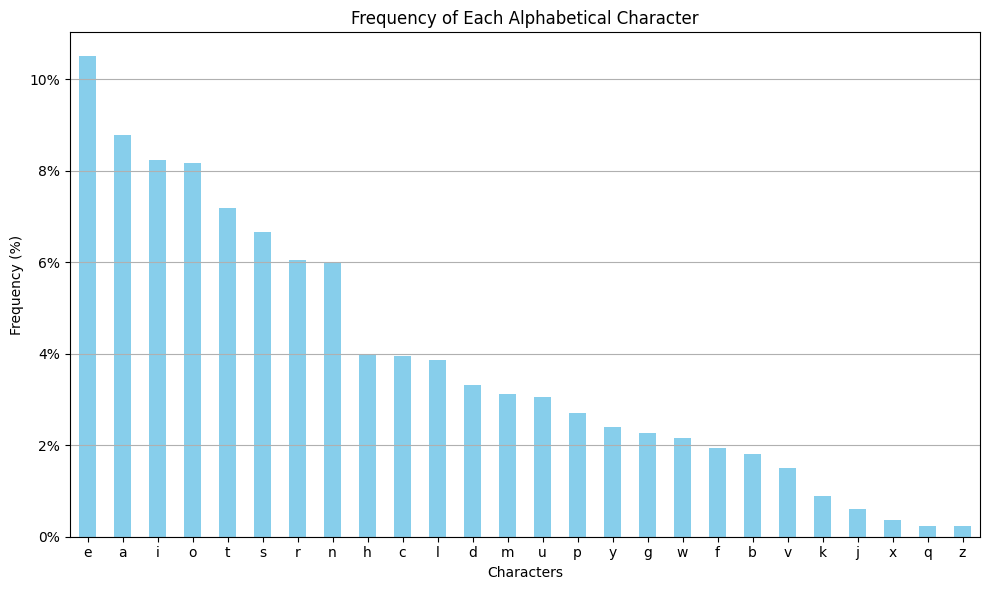

In [164]:
import string

df['key'] = df['key'].str.lower()


alphabetical_data = df[df['key'].str.lower().isin(list(string.ascii_lowercase))]

frequency = alphabetical_data['key'].value_counts()

# Convert frequencies to percentages
total_characters = frequency.sum()
frequency_percentage = (frequency / total_characters) * 100

# Sort the frequencies in descending order
sorted_frequency_percentage = frequency_percentage.sort_values(ascending=False)

# Plot the frequencies
plt.figure(figsize=(10, 6))
sorted_frequency_percentage.plot(kind='bar', color='skyblue')
plt.title('Frequency of Each Alphabetical Character')
plt.xlabel('Characters')
plt.ylabel('Frequency (%)')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0f}%'.format(x)))
# Show the plot
plt.tight_layout()
plt.show()

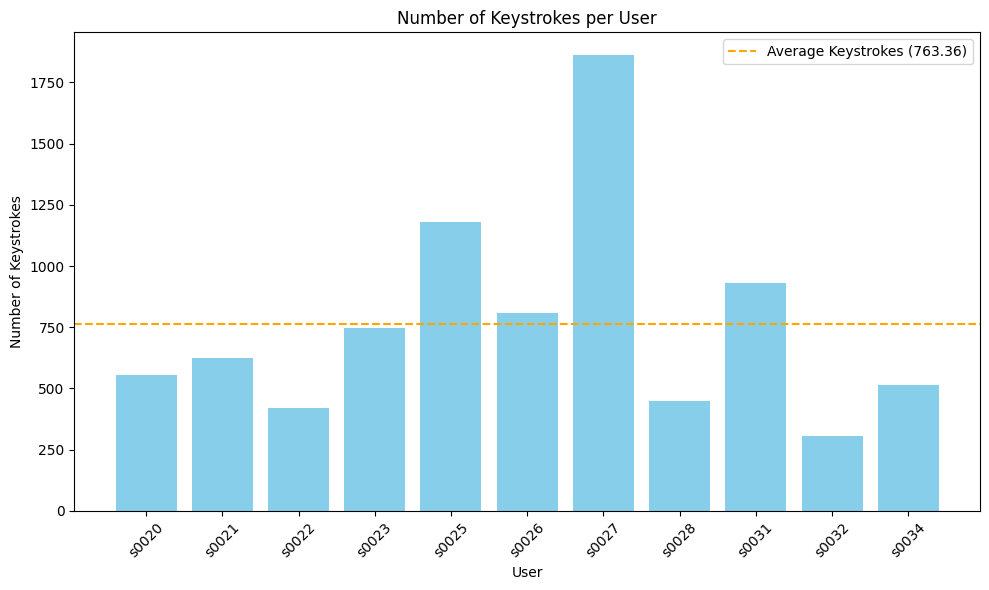

In [165]:
keystrokes_per_user = df.groupby('subject').size().reset_index(name='Keystrokes')
avg_keystrokes = keystrokes_per_user['Keystrokes'].mean()
plt.figure(figsize=(10, 6))
plt.bar(keystrokes_per_user['subject'], keystrokes_per_user['Keystrokes'], color='skyblue')
plt.axhline(y=avg_keystrokes, color='orange', linestyle='--', label=f'Average Keystrokes ({avg_keystrokes:.2f})')
plt.xlabel('User')
plt.ylabel('Number of Keystrokes')
plt.title('Number of Keystrokes per User')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

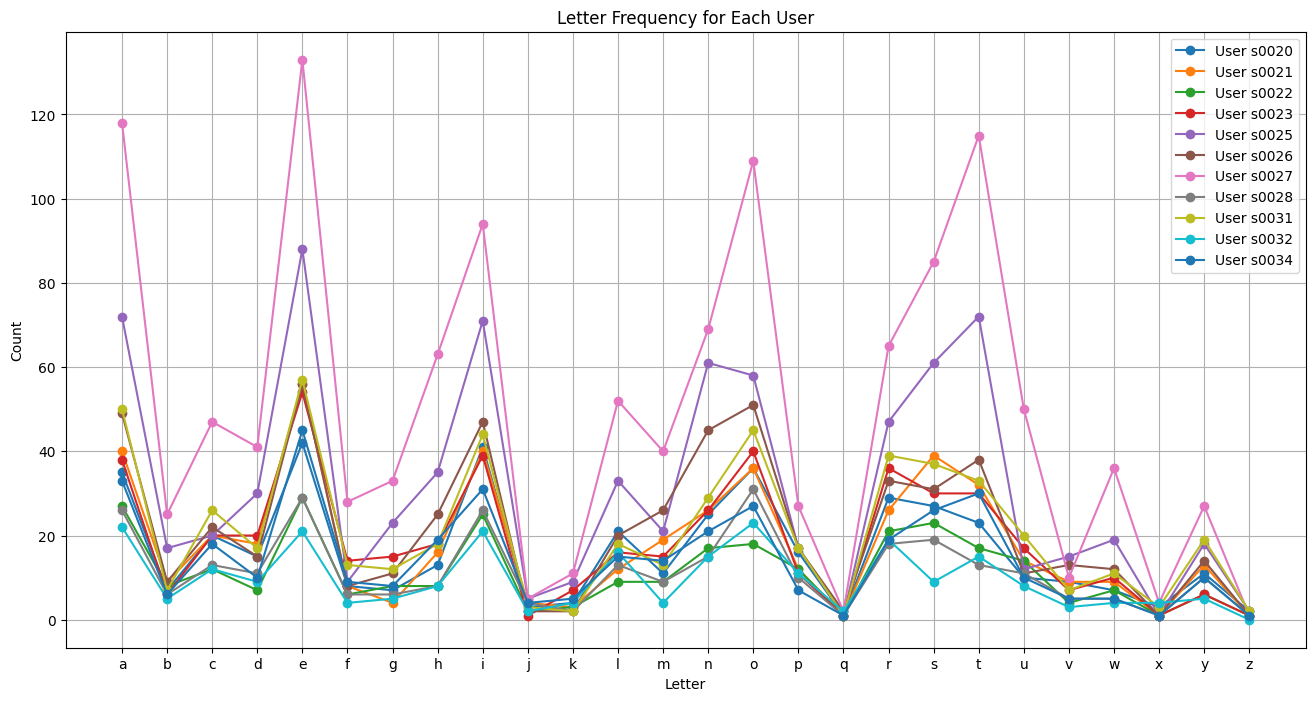

In [166]:
import string
from collections import Counter

alphabet_keys = set(string.ascii_lowercase)
df_filtered = df[df['key'].isin(alphabet_keys)]

# Group by subject and aggregate keys into a list
user_key_counts = df_filtered.groupby('subject')['key'].apply(list).reset_index()

# Create a dictionary to store counts per user
user_key_counts_dict = {row['subject']: dict(pd.Series(row['key']).value_counts()) for _, row in user_key_counts.iterrows()}

# Prepare data for plotting
alphabet_list = sorted(list(alphabet_keys))
user_letter_counts = {user: [user_key_counts_dict[user].get(letter, 0) for letter in alphabet_list] for user in user_key_counts_dict}

# Plotting
plt.figure(figsize=(16, 8))

for user, counts in user_letter_counts.items():
    plt.plot(alphabet_list, counts, marker='o', label=f'User {user}')

plt.xlabel('Letter')
plt.ylabel('Count')
plt.title('Letter Frequency for Each User')
plt.legend()
plt.xticks()
plt.grid(True)
plt.show()

In [167]:
# Define a custom mapping for non-printable keys
custom_key_map = {
    'shift': 1000,       # Assigning 1000 for 'shift'
    'backspace': 1001,   # Assigning 1001 for 'backspace'
    'space':1002,
    'none':1003,
    'delete':1004,
    'shift_r':1005,
    'ctrl_l':1006,
    'num_lock':1007,
    'left':1008,
    'right':1009,
    'caps_lock':1010,
    'enter':1011,
    'tab':1012,
    'alt_l':1013,
    'scroll_lock':1014
    # Add other custom mappings as needed
}

def key_to_ascii(key):
    if key in custom_key_map:
        return custom_key_map[key]
    elif isinstance(key, str):
        return int(''.join(str(ord(char)) for char in key))
    return key

df['key'] = df['key'].apply(key_to_ascii)
csv_file_path = 'processed_keys.csv'
df.to_csv(csv_file_path, index=False)
print(df)

     subject   key       DU       UD         DD       UU  Overlapped  \
0      s0034  1000  0.33557  1.03070  383.35261  0.09957           1   
1      s0034   109  0.15325  0.93113  383.35261  1.08439           0   
2      s0034  1001  0.15762  0.92795    0.58901  1.08557           0   
3      s0034   116  0.09175  0.09036    0.23976  0.18212           0   
4      s0034   111  0.14044  0.14800    0.75439  0.28844           0   
...      ...   ...      ...      ...        ...      ...         ...   
8392   s0027   110  0.00200  0.43241    0.59114  0.43440           0   
8393   s0027   105  0.00200  0.58914    0.24862  0.59115           0   
8394   s0027   111  0.00200  0.24662    0.44768  0.24862           0   
8395   s0027   115  0.00200  0.44568    0.20777  0.44768           0   
8396   s0027   105  0.00200  0.20577    0.09890  0.20777           0   

      Number of Errors  
0                    0  
1                    0  
2                    1  
3                    1  
4         

In [168]:
target_subject_id = 's0034'

df['is_target'] = (df['subject'] == target_subject_id).astype(int)

target_data = df[df['subject'] == target_subject_id]
impostor_data = df[df['subject'] != target_subject_id]

target_train, target_test = train_test_split(target_data, test_size=0.2)
impostor_train_full, impostor_test_full = train_test_split(impostor_data, test_size=0.2)

proportion_train = 0.8
proportion_test = 0.3

impostor_train = impostor_train_full.sample(frac=proportion_train)
impostor_test = impostor_test_full.sample(frac=proportion_test)

train_data = pd.concat([target_train, impostor_train])
test_data = pd.concat([target_test, impostor_test])

features = ['key','DU','UD','DD','UU','Overlapped','Number of Errors']
X_train = train_data[features]
y_train = train_data['is_target']
X_test = test_data[features]
y_test = test_data['is_target']

In [169]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5455, 7)
(5455,)
(577, 7)
(577,)


# XGBoost

In [170]:
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.001, 0.01],
    'max_depth': [5, 7],
    'min_child_weight': [5, 10],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

xgb_model = xgb.XGBClassifier()

cv = StratifiedKFold(n_splits=3, shuffle=True)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, pre_dispatch = 2,
                           scoring='accuracy', cv=cv, verbose=1, n_jobs=None)

grid_search.fit(X_train, y_train)
best_xgb_model = grid_search.best_estimator_

y_prob_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob_xgb, pos_label=1)

fnr_xgb = 1 - tpr_xgb
frr_xgb = 1 - tpr_xgb
far_xgb = fpr_xgb

roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)

eer_threshold = thresholds_xgb[np.nanargmin(np.absolute((fnr_xgb - fpr_xgb)))]
eer_xgb_fpr = fpr_xgb[np.nanargmin(np.absolute((fnr_xgb - fpr_xgb)))]
eer_xgb_fnr = fnr_xgb[np.nanargmin(np.absolute((fnr_xgb - fpr_xgb)))]

y_pred_xgb = best_xgb_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)

cv_scores = grid_search.cv_results_['mean_test_score']
cv_std = grid_search.cv_results_['std_test_score']

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
training_accuracy_xgb = grid_search.best_score_


Fitting 3 folds for each of 96 candidates, totalling 288 fits


# Deep Learning Nadam Optimization

In [171]:
def create_nadam_model():
    model = Sequential()
    model.add(Dense(512, activation='tanh'))
    model.add(Dense(256, activation='tanh'))
    model.add(Dense(128, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Nadam(), loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model

# Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True)

roc_auc_scores_nadam = []
eers_nadam = []
conf_matrices_nadam = []
cv_scores_nadam = []

# Ensure X_train and y_train are numpy arrays
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train

for train_index, test_index in cv.split(X_train, y_train):
    X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

    nadam_model = KerasClassifier(build_fn=create_nadam_model, epochs=100, batch_size=32, verbose=0)

    nadam_model.fit(X_train_cv, y_train_cv)

    y_prob_nadam = nadam_model.predict_proba(X_test_cv)[:, 1]
    
    roc_auc_nadam = roc_auc_score(y_test_cv, y_prob_nadam)
    roc_auc_scores_nadam.append(roc_auc_nadam)

    fpr_nadam, tpr_nadam, thresholds_nadam = roc_curve(y_test_cv, y_prob_nadam)
    eer_threshold_nadam = thresholds_nadam[np.nanargmin(np.absolute((fpr_nadam - (1 - tpr_nadam))))]
    eer_nadam = (fpr_nadam[np.nanargmin(np.absolute((fpr_nadam - (1 - tpr_nadam))))] + (1 - tpr_nadam)[np.nanargmin(np.absolute((fpr_nadam - (1 - tpr_nadam))))]) / 2
    eers_nadam.append(eer_nadam)

    y_pred_binary_nadam = (y_prob_nadam > 0.5).astype(int)
    conf_matrix_nadam = confusion_matrix(y_test_cv, y_pred_binary_nadam)
    conf_matrices_nadam.append(conf_matrix_nadam)
    
    cv_score = accuracy_score(y_test_cv, y_pred_binary_nadam)
    cv_scores_nadam.append(cv_score)

# Grid search parameters for Nadam model
param_grid_nadam = {
    'epochs': [50,100],
    'batch_size': [64, 128]
}

grid_search_nadam = GridSearchCV(estimator=KerasClassifier(build_fn=create_nadam_model, verbose=0),
                                 param_grid=param_grid_nadam, cv=cv, scoring='accuracy')

grid_search_nadam.fit(X_train, y_train)

best_nadam_model = grid_search_nadam.best_estimator_

y_prob_best_nadam = best_nadam_model.predict_proba(X_test)[:, 1]

roc_auc_best_nadam = roc_auc_score(y_test, y_prob_best_nadam)

fpr_best_nadam, tpr_best_nadam, thresholds_best_nadam = roc_curve(y_test, y_prob_best_nadam)
eer_threshold_best_nadam = thresholds_best_nadam[np.nanargmin(np.absolute((fpr_best_nadam - (1 - tpr_best_nadam))))]
eer_best_nadam = (fpr_best_nadam[np.nanargmin(np.absolute((fpr_best_nadam - (1 - tpr_best_nadam))))] + (1 - tpr_best_nadam)[np.nanargmin(np.absolute((fpr_best_nadam - (1 - tpr_best_nadam))))]) / 2

y_pred_binary_best_nadam = (y_prob_best_nadam > 0.5).astype(int)

accuracy_best_nadam = accuracy_score(y_test, y_pred_binary_best_nadam)
precision_best_nadam = precision_score(y_test, y_pred_binary_best_nadam)
recall_best_nadam = recall_score(y_test, y_pred_binary_best_nadam)

cv_nadam_results = grid_search_nadam.cv_results_
cv_nadam_scores = cv_nadam_results['mean_test_score']
cv_nadam_std = cv_nadam_results['std_test_score']

cm_best_nadam = confusion_matrix(y_test, y_pred_binary_best_nadam)
training_accuracy_nadam = grid_search_nadam.best_score_

C:\Users\Alexandros Mikelis\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


35/35 [==============================] - 0s 2ms/step


C:\Users\Alexandros Mikelis\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


35/35 [==============================] - 0s 2ms/step


C:\Users\Alexandros Mikelis\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


35/35 [==============================] - 0s 2ms/step


C:\Users\Alexandros Mikelis\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


35/35 [==============================] - 0s 2ms/step


C:\Users\Alexandros Mikelis\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


35/35 [==============================] - 0s 2ms/step


C:\Users\Alexandros Mikelis\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:53: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


19/19 [==============================] - 0s 1ms/step


# LSTM

In [172]:
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1],1), return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

roc_auc_scores_lstm = []
eers_lstm = []
conf_matrices_lstm = []
cv_scores_lstm = []

X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train

for train_index, test_index in cv.split(X_train, y_train):
    X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

    X_train_cv_lstm = X_train_cv.reshape(X_train_cv.shape[0], X_train_cv.shape[1], 1)
    X_test_cv_lstm = X_test_cv.reshape(X_test_cv.shape[0], X_test_cv.shape[1], 1)

    lstm_model = KerasClassifier(build_fn=create_lstm_model, epochs=100, batch_size=32, verbose=0)

    lstm_model.fit(X_train_cv_lstm, y_train_cv)

    y_prob_lstm = lstm_model.predict_proba(X_test_cv_lstm)[:, 1]
    
    roc_auc_lstm = roc_auc_score(y_test_cv, y_prob_lstm)
    roc_auc_scores_lstm.append(roc_auc_lstm)

    fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test_cv, y_prob_lstm)
    eer_threshold_lstm = thresholds_lstm[np.nanargmin(np.absolute((fpr_lstm - (1 - tpr_lstm))))]
    eer_lstm = (fpr_lstm[np.nanargmin(np.absolute((fpr_lstm - (1 - tpr_lstm))))] + (1 - tpr_lstm)[np.nanargmin(np.absolute((fpr_lstm - (1 - tpr_lstm))))]) / 2
    eers_lstm.append(eer_lstm)

    y_pred_binary_lstm = (y_prob_lstm > 0.5).astype(int)
    conf_matrix_lstm = confusion_matrix(y_test_cv, y_pred_binary_lstm)
    conf_matrices_lstm.append(conf_matrix_lstm)
    
    cv_score = accuracy_score(y_test_cv, y_pred_binary_lstm)
    cv_scores_lstm.append(cv_score)

param_grid_lstm = {
    'epochs': [50],
    'batch_size': [32, 64]
}

grid_search = GridSearchCV(estimator=KerasClassifier(build_fn=create_lstm_model, verbose=0),
                           param_grid=param_grid_lstm, cv=cv, scoring='accuracy')

grid_search.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train)

best_lstm_model = grid_search.best_estimator_

X_test_lstm = X_test.values.reshape(X_test.values.shape[0], X_test.values.shape[1], 1)
y_prob_best_lstm = best_lstm_model.predict_proba(X_test_lstm)[:, 1]

roc_auc_best_lstm = roc_auc_score(y_test, y_prob_best_lstm)

fpr_best_lstm, tpr_best_lstm, thresholds_best_lstm = roc_curve(y_test, y_prob_best_lstm)
eer_threshold_best_lstm = thresholds_best_lstm[np.nanargmin(np.absolute((fpr_best_lstm - (1 - tpr_best_lstm))))]
eer_best_lstm = (fpr_best_lstm[np.nanargmin(np.absolute((fpr_best_lstm - (1 - tpr_best_lstm))))] + (1 - tpr_best_lstm)[np.nanargmin(np.absolute((fpr_best_lstm - (1 - tpr_best_lstm))))]) / 2

y_pred_binary_best_lstm = (y_prob_best_lstm > 0.5).astype(int)

accuracy_lstm = accuracy_score(y_test, y_pred_binary_best_lstm)
precision_best_lstm = precision_score(y_test, y_pred_binary_best_lstm)
recall_best_lstm = recall_score(y_test, y_pred_binary_best_lstm)

cv_lstm_results = grid_search.cv_results_
cv_lstm_scores = cv_lstm_results['mean_test_score']
cv_lstm_std = cv_lstm_results['std_test_score']

cm_best_lstm = confusion_matrix(y_test, y_pred_binary_best_lstm)
training_accuracy_lstm = grid_search.best_score_


C:\Users\Alexandros Mikelis\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


57/57 [==============================] - 1s 4ms/step


C:\Users\Alexandros Mikelis\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


57/57 [==============================] - 1s 3ms/step


C:\Users\Alexandros Mikelis\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


57/57 [==============================] - 1s 3ms/step


C:\Users\Alexandros Mikelis\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:52: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


19/19 [==============================] - 1s 3ms/step


# CNN

In [173]:
def create_cnn_model():
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='tanh', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=['binary_accuracy'])
    return model

# Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

roc_auc_scores_cnn = []
eers_cnn = []
conf_matrices_cnn = []
cv_scores_cnn = []

# Ensure X_train and y_train are numpy arrays
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train

for train_index, test_index in cv.split(X_train, y_train):
    X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

    X_train_cv_cnn = X_train_cv.reshape(X_train_cv.shape[0], X_train_cv.shape[1], 1)
    X_test_cv_cnn = X_test_cv.reshape(X_test_cv.shape[0], X_test_cv.shape[1], 1)

    cnn_model = KerasClassifier(build_fn=create_cnn_model, epochs=100, batch_size=32, verbose=0)

    cnn_model.fit(X_train_cv_cnn, y_train_cv)

    y_prob_cnn = cnn_model.predict_proba(X_test_cv_cnn)[:, 1]
    
    roc_auc_cnn = roc_auc_score(y_test_cv, y_prob_cnn)
    roc_auc_scores_cnn.append(roc_auc_cnn)

    fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test_cv, y_prob_cnn)
    eer_threshold_cnn = thresholds_cnn[np.nanargmin(np.absolute((fpr_cnn - (1 - tpr_cnn))))]
    eer_cnn = (fpr_cnn[np.nanargmin(np.absolute((fpr_cnn - (1 - tpr_cnn))))] + (1 - tpr_cnn)[np.nanargmin(np.absolute((fpr_cnn - (1 - tpr_cnn))))]) / 2
    eers_cnn.append(eer_cnn)

    y_pred_binary_cnn = (y_prob_cnn > 0.5).astype(int)
    conf_matrix_cnn = confusion_matrix(y_test_cv, y_pred_binary_cnn)
    conf_matrices_cnn.append(conf_matrix_cnn)
    
    cv_score = accuracy_score(y_test_cv, y_pred_binary_cnn)
    cv_scores_cnn.append(cv_score)

# Grid search parameters for CNN model
param_grid_cnn = {
    'epochs': [100],
    'batch_size': [32, 64]
}

grid_search_cnn = GridSearchCV(estimator=KerasClassifier(build_fn=create_cnn_model, verbose=0),
                               param_grid=param_grid_cnn, cv=cv, scoring='accuracy')

grid_search_cnn.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train)

best_cnn_model = grid_search_cnn.best_estimator_

X_test_cnn = X_test.values.reshape(X_test.values.shape[0], X_test.values.shape[1], 1)
y_prob_best_cnn = best_cnn_model.predict_proba(X_test_cnn)[:, 1]

roc_auc_best_cnn = roc_auc_score(y_test, y_prob_best_cnn)

fpr_best_cnn, tpr_best_cnn, thresholds_best_cnn = roc_curve(y_test, y_prob_best_cnn)
eer_threshold_best_cnn = thresholds_best_cnn[np.nanargmin(np.absolute((fpr_best_cnn - (1 - tpr_best_cnn))))]
eer_best_cnn = (fpr_best_cnn[np.nanargmin(np.absolute((fpr_best_cnn - (1 - tpr_best_cnn))))] + (1 - tpr_best_cnn)[np.nanargmin(np.absolute((fpr_best_cnn - (1 - tpr_best_cnn))))]) / 2

y_pred_binary_best_cnn = (y_prob_best_cnn > 0.5).astype(int)

accuracy_best_cnn = accuracy_score(y_test, y_pred_binary_best_cnn)
precision_best_cnn = precision_score(y_test, y_pred_binary_best_cnn)
recall_best_cnn = recall_score(y_test, y_pred_binary_best_cnn)

cv_cnn_results = grid_search_cnn.cv_results_
cv_cnn_scores = cv_cnn_results['mean_test_score']
cv_cnn_std = cv_cnn_results['std_test_score']

cm_best_cnn = confusion_matrix(y_test, y_pred_binary_best_cnn)
training_accuracy_cnn = grid_search_cnn.best_score_

C:\Users\Alexandros Mikelis\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:30: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


57/57 [==============================] - 0s 734us/step


C:\Users\Alexandros Mikelis\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:30: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


57/57 [==============================] - 0s 733us/step


C:\Users\Alexandros Mikelis\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:30: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


57/57 [==============================] - 0s 798us/step


C:\Users\Alexandros Mikelis\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:57: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


19/19 [==============================] - 0s 723us/step


# SVM

In [174]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

roc_auc_scores_svm = []
eers_svm = []
conf_matrices_svm = []
cv_scores_svm = []

for train_index, test_index in cv.split(X_train_scaled, y_train):
    X_train_cv, X_test_cv = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

    svm_model = SVC(probability=True)

    svm_model.fit(X_train_cv, y_train_cv)

    y_prob_svm = svm_model.predict_proba(X_test_cv)[:, 1]
    
    roc_auc_svm = roc_auc_score(y_test_cv, y_prob_svm)
    roc_auc_scores_svm.append(roc_auc_svm)

    fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test_cv, y_prob_svm)
    eer_threshold_svm = thresholds_svm[np.nanargmin(np.absolute((fpr_svm - (1 - tpr_svm))))]
    eer_svm = (fpr_svm[np.nanargmin(np.absolute((fpr_svm - (1 - tpr_svm))))] + (1 - tpr_svm)[np.nanargmin(np.absolute((fpr_svm - (1 - tpr_svm))))]) / 2
    eers_svm.append(eer_svm)

    y_pred_binary_svm = (y_prob_svm > 0.5).astype(int)
    conf_matrix_svm = confusion_matrix(y_test_cv, y_pred_binary_svm)
    conf_matrices_svm.append(conf_matrix_svm)
    
    cv_score = accuracy_score(y_test_cv, y_pred_binary_svm)
    cv_scores_svm.append(cv_score)

# Perform grid search to find the best hyperparameters
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [10.0, 5.0, 1.0, 0.1],
    'kernel': ['rbf']
}

grid_search = GridSearchCV(SVC(probability=True), param_grid, cv=cv, scoring='accuracy')

grid_search.fit(X_train_scaled, y_train)

best_svm_model = grid_search.best_estimator_

y_prob_best_svm = best_svm_model.predict_proba(X_test_scaled)[:, 1]

roc_auc_best_svm = roc_auc_score(y_test, y_prob_best_svm)

fpr_best_svm, tpr_best_svm, thresholds_best_svm = roc_curve(y_test, y_prob_best_svm)
eer_threshold_best_svm = thresholds_best_svm[np.nanargmin(np.absolute((fpr_best_svm - (1 - tpr_best_svm))))]
eer_best_svm = (fpr_best_svm[np.nanargmin(np.absolute((fpr_best_svm - (1 - tpr_best_svm))))] + (1 - tpr_best_svm)[np.nanargmin(np.absolute((fpr_best_svm - (1 - tpr_best_svm))))]) / 2

y_pred_binary_best_svm = (y_prob_best_svm > 0.5).astype(int)

accuracy_svm = accuracy_score(y_test, y_pred_binary_best_svm)
precision_best_svm = precision_score(y_test, y_pred_binary_best_svm)
recall_best_svm = recall_score(y_test, y_pred_binary_best_svm)

cv_svm_results = grid_search.cv_results_
cv_svm_scores = cv_svm_results['mean_test_score']
cv_svm_std = cv_svm_results['std_test_score']

cm_best_svm = confusion_matrix(y_test, y_pred_binary_best_svm)
training_accuracy_svm = grid_search.best_score_

c:\Users\Alexandros Mikelis\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


# k-NN

In [175]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values if isinstance(X_train, pd.DataFrame) else X_train)
X_test_scaled = scaler.transform(X_test.values if isinstance(X_test, pd.DataFrame) else X_test)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

roc_auc_scores_knn = []
eers_knn = []
conf_matrices_knn = []
cv_scores_knn = []

for train_index, test_index in cv.split(X_train_scaled, y_train):
    X_train_cv, X_test_cv = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

    knn_model = KNeighborsClassifier()

    knn_model.fit(X_train_cv, y_train_cv)

    y_prob_knn = knn_model.predict_proba(X_test_cv)[:, 1]
    
    roc_auc_knn = roc_auc_score(y_test_cv, y_prob_knn)
    roc_auc_scores_knn.append(roc_auc_knn)

    fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test_cv, y_prob_knn)
    eer_threshold_knn = thresholds_knn[np.nanargmin(np.absolute((fpr_knn - (1 - tpr_knn))))]
    eer_knn = (fpr_knn[np.nanargmin(np.absolute((fpr_knn - (1 - tpr_knn))))] + (1 - tpr_knn)[np.nanargmin(np.absolute((fpr_knn - (1 - tpr_knn))))]) / 2
    eers_knn.append(eer_knn)

    y_pred_binary_knn = (y_prob_knn > 0.5).astype(int)
    conf_matrix_knn = confusion_matrix(y_test_cv, y_pred_binary_knn)
    conf_matrices_knn.append(conf_matrix_knn)
    
    cv_score = accuracy_score(y_test_cv, y_pred_binary_knn)
    cv_scores_knn.append(cv_score)

# Perform grid search to find the best hyperparameters
param_grid = {
    'n_neighbors': [7, 13, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, scoring='accuracy')

grid_search.fit(X_train_scaled, y_train)

best_knn_model = grid_search.best_estimator_

y_prob_best_knn = best_knn_model.predict_proba(X_test_scaled)[:, 1]

roc_auc_best_knn = roc_auc_score(y_test, y_prob_best_knn)

fpr_best_knn, tpr_best_knn, thresholds_best_knn = roc_curve(y_test, y_prob_best_knn)
eer_threshold_best_knn = thresholds_best_knn[np.nanargmin(np.absolute((fpr_best_knn - (1 - tpr_best_knn))))]
eer_best_knn = (fpr_best_knn[np.nanargmin(np.absolute((fpr_best_knn - (1 - tpr_best_knn))))] + (1 - tpr_best_knn)[np.nanargmin(np.absolute((fpr_best_knn - (1 - tpr_best_knn))))]) / 2

y_pred_binary_best_knn = (y_prob_best_knn > 0.5).astype(int)

accuracy_knn = accuracy_score(y_test, y_pred_binary_best_knn)
precision_best_knn = precision_score(y_test, y_pred_binary_best_knn)
recall_best_knn = recall_score(y_test, y_pred_binary_best_knn)

cv_knn_results = grid_search.cv_results_
cv_knn_scores = cv_knn_results['mean_test_score']
cv_knn_std = cv_knn_results['std_test_score']

cm_best_knn = confusion_matrix(y_test, y_pred_binary_best_knn)
training_accuracy_knn = grid_search.best_score_

In [176]:
TN_xgb, FP_xgb, FN_xgb, TP_xgb = cm_xgb.ravel()
TN_nadam, FP_nadam, FN_nadam, TP_nadam = cm_best_nadam.ravel()
TN_lstm, FP_lstm, FN_lstm, TP_lstm = cm_best_lstm.ravel()
TN_cnn, FP_cnn, FN_cnn, TP_cnn = cm_best_cnn.ravel()
TN_svm, FP_svm, FN_svm, TP_svm = cm_best_svm.ravel()
TN_knn, FP_knn, FN_knn, TP_knn = cm_best_knn.ravel()

# Calculate FAR and FRR
FAR_xgb = FP_xgb / (FP_xgb + TN_xgb + FN_xgb + TP_xgb)
FRR_xgb = FN_xgb / (FP_xgb + TN_xgb + FN_xgb + TP_xgb)

FAR_nadam = FP_nadam / (FP_nadam + TN_nadam + FN_nadam + TP_nadam)
FRR_nadam = FN_nadam / (FP_nadam + TN_nadam + FN_nadam + TP_nadam)

FAR_lstm = FP_lstm / (FP_lstm + TN_lstm + FN_lstm + TP_lstm)
FRR_lstm = FN_lstm / (FP_lstm + TN_lstm + FN_lstm + TP_lstm)

FAR_cnn = FP_cnn / (FP_cnn + TN_cnn + FN_cnn + TP_cnn)
FRR_cnn = FN_cnn / (FP_cnn + TN_cnn + FN_cnn + TP_cnn)

FAR_svm = FP_svm / (FP_svm + TN_svm + FN_svm + TP_svm)
FRR_svm = FN_svm / (FP_svm + TN_svm + FN_svm + TP_svm)

FAR_knn = FP_knn / (FP_knn + TN_knn + FN_knn + TP_knn)
FRR_knn = FN_knn / (FP_knn + TN_knn + FN_knn + TP_knn)

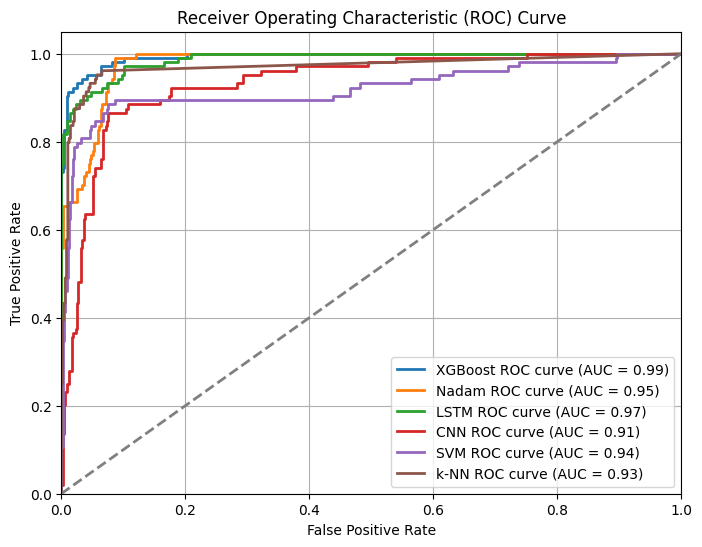

In [177]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGBoost ROC curve (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_best_nadam, tpr_best_nadam, lw=2, label=f'Nadam ROC curve (AUC = {roc_auc_nadam:.2f})')
plt.plot(fpr_best_lstm, tpr_best_lstm, lw=2, label=f'LSTM ROC curve (AUC = {roc_auc_lstm:.2f})')
plt.plot(fpr_best_cnn, tpr_best_cnn, lw=2, label=f'CNN ROC curve (AUC = {roc_auc_cnn:.2f})')
plt.plot(fpr_best_svm, tpr_best_svm, lw=2, label=f'SVM ROC curve (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_best_knn, tpr_best_knn, lw=2, label=f'k-NN ROC curve (AUC = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

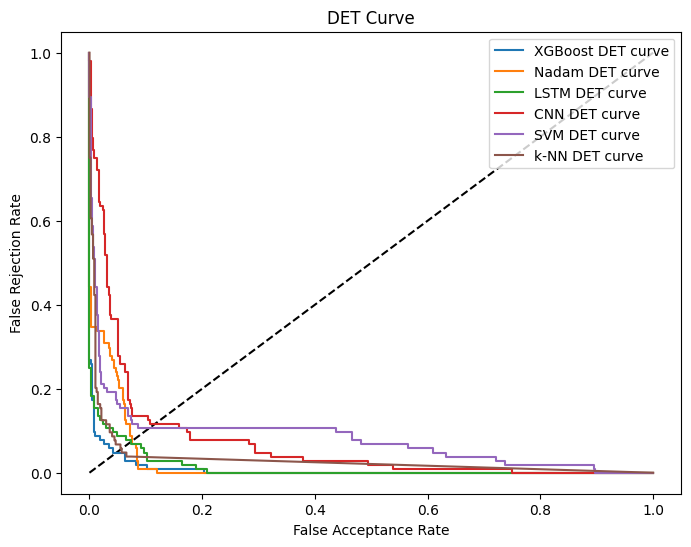

In [178]:
# Plot FRR vs. FAR curve DET
plt.figure(figsize = (8,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(far_xgb, frr_xgb, label='XGBoost DET curve')
plt.plot(fpr_best_nadam, 1 - tpr_best_nadam, label='Nadam DET curve')
plt.plot(fpr_best_lstm, 1 - tpr_best_lstm, label='LSTM DET curve')
plt.plot(fpr_best_cnn, 1 - tpr_best_cnn, label='CNN DET curve')
plt.plot(fpr_best_svm, 1 - tpr_best_svm, label='SVM DET curve')
plt.plot(fpr_best_knn, 1 - tpr_best_knn, label='k-NN DET curve')
plt.xlabel('False Acceptance Rate')
plt.ylabel('False Rejection Rate')
plt.title('DET Curve')
plt.legend(loc='upper right')
plt.show()

In [179]:
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC AUC', 'Precision', 'Recall', 'EER','FAR','FRR','Training Accuracy','Cross validation Accuracy'],
    'XGBoost': ["{:.2f}%".format(accuracy_xgb*100), roc_auc_xgb, precision_xgb, recall_xgb, "{:.2f}%".format(eer_xgb_fpr*100),f"{FAR_xgb*100:.2f}%",f"{FRR_xgb*100:.2f}%",training_accuracy_xgb, "{:.4f} ± {:.4f}".format(cv_scores.mean(), cv_std.mean())],
    'Nadam': ["{:.2f}%".format(accuracy_best_nadam*100), roc_auc_best_nadam, precision_best_nadam, recall_best_nadam, "{:.2f}%".format(eer_best_nadam*100),f"{FAR_nadam*100:.2f}%",f"{FRR_nadam*100:.2f}%",training_accuracy_nadam, "{:.4f} ± {:.4f}".format(cv_nadam_scores.mean(), cv_nadam_std.mean())],
    'LSTM': ["{:.2f}%".format(accuracy_lstm*100), roc_auc_best_lstm, precision_best_lstm, recall_best_lstm, "{:.2f}%".format(eer_best_lstm*100),f"{FAR_lstm*100:.2f}%",f"{FRR_lstm*100:.2f}%",training_accuracy_lstm, "{:.4f} ± {:.4f}".format(cv_lstm_scores.mean(), cv_lstm_std.mean())],
    'CNN': ["{:.2f}%".format(accuracy_best_cnn*100), roc_auc_best_cnn, precision_best_cnn, recall_best_cnn, "{:.2f}%".format(eer_best_cnn*100),f"{FAR_cnn*100:.2f}%",f"{FRR_cnn*100:.2f}%",training_accuracy_cnn, "{:.4f} ± {:.4f}".format(cv_cnn_scores.mean(), cv_cnn_std.mean())],
    'SVM': ["{:.2f}%".format(accuracy_svm*100), roc_auc_best_svm, precision_best_svm, recall_best_svm, "{:.2f}%".format(eer_best_svm*100),f"{FAR_svm*100:.2f}%",f"{FRR_svm*100:.2f}%",training_accuracy_svm, "{:.4f} ± {:.4f}".format(cv_svm_scores.mean(), cv_svm_std.mean())],
    'k-NN': ["{:.2f}%".format(accuracy_knn*100), roc_auc_best_knn, precision_best_knn, recall_best_knn, "{:.2f}%".format(eer_best_knn*100),f"{FAR_knn*100:.2f}%",f"{FRR_knn*100:.2f}%",training_accuracy_knn, "{:.4f} ± {:.4f}".format(cv_knn_scores.mean(), cv_knn_std.mean())],
})

metrics_df.transpose()

,0,1,2,3,4,5,6,7,8
Metric,Accuracy,ROC AUC,Precision,Recall,EER,FAR,FRR,Training Accuracy,Cross validation Accuracy
XGBoost,96.53%,0.992763,0.977273,0.826923,4.23%,0.35%,3.12%,0.982035,0.9715 ± 0.0015
Nadam,93.07%,0.979306,0.984848,0.625,7.17%,0.17%,6.76%,0.952521,0.9425 ± 0.0176
LSTM,95.15%,0.987254,1.0,0.730769,7.55%,0.00%,4.85%,0.957469,0.9571 ± 0.0058
CNN,85.44%,0.934095,0.884615,0.221154,11.16%,0.52%,14.04%,0.928323,0.9280 ± 0.0030
SVM,90.12%,0.921796,0.927273,0.490385,9.62%,0.69%,9.19%,0.954721,0.9334 ± 0.0012
k-NN,94.63%,0.970158,0.939759,0.75,5.74%,0.87%,4.51%,0.960953,0.9551 ± 0.0023


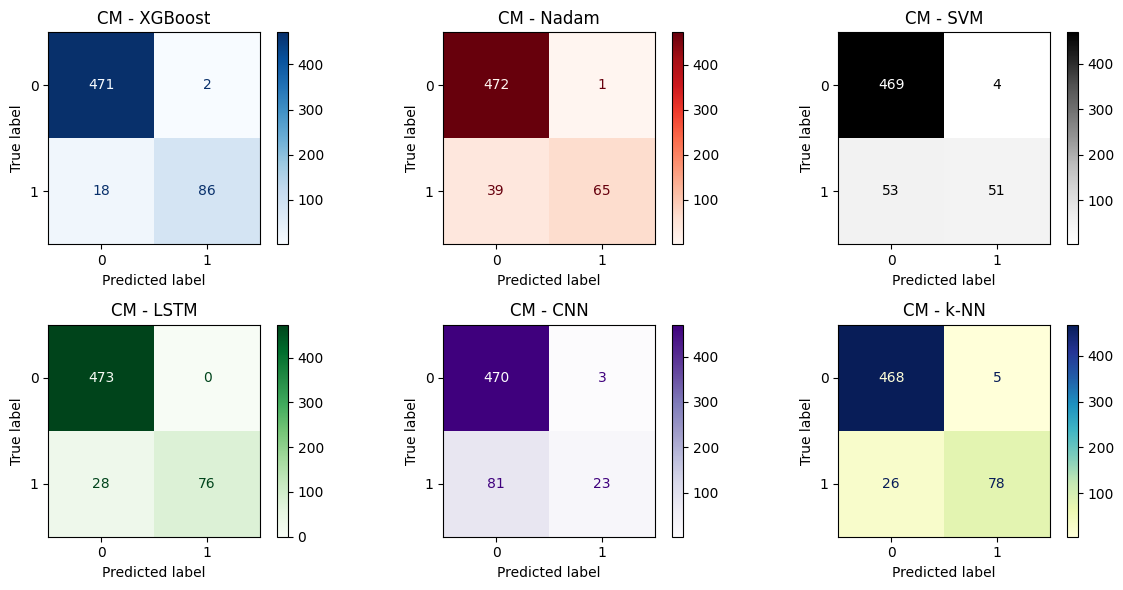

In [180]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=best_xgb_model.classes_)
disp_xgb.plot(ax=axs[0,0], cmap='Blues', values_format='d')
axs[0,0].set_title('CM - XGBoost')

disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_best_nadam, display_labels=best_nadam_model.classes_)
disp_nn.plot(ax=axs[0,1], cmap='Reds', values_format='d')
axs[0,1].set_title('CM - Nadam')

disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_best_lstm, display_labels=best_lstm_model.classes_)
disp_lstm.plot(ax=axs[1,0], cmap='Greens', values_format='d')
axs[1,0].set_title('CM - LSTM')

disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_best_cnn, display_labels=best_cnn_model.classes_)
disp_lstm.plot(ax=axs[1,1], cmap='Purples', values_format='d')
axs[1,1].set_title('CM - CNN')

disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_best_svm, display_labels=best_svm_model.classes_)
disp_nn.plot(ax=axs[0,2], cmap='Greys', values_format='d')
axs[0,2].set_title('CM - SVM')

disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_best_knn, display_labels=best_knn_model.classes_)
disp_nn.plot(ax=axs[1,2], cmap='YlGnBu', values_format='d')
axs[1,2].set_title('CM - k-NN')

plt.tight_layout()
plt.show()